## The purpose of the Capstone 1 project is to provide a list of recommendation to a gamer so that they may find new games that will interest them.

"Content based game recommendation" will calculate cosine similarity between reviews from multiple games to provide a list of recommended games for people who have purchased and has played games from STEAM

Cleaned game review data is imported from the pickle file from "Data Clean and EDA"

In [1]:
import pickle
file_name='cleaned_review.p' # every reviews that were pulled from every game on steam website.
review_df=pickle.load(open(file_name,"rb"))
steamapp_dict=pickle.load(open("steam.p","rb"))

In [2]:
review_df.columns

Index(['author', 'review', 'game_name', 'game_ids'], dtype='object')

In [3]:
test_id=76561198141485825

In [4]:
len(steamapp_dict)

85351

The default number of reviews obtained from the API is 20. get_reviews will retrieve review data from each game using its id and get_all_reviews will attempt to retrieve more reviews by looping over multiple iteration.

In [5]:
def get_reviews(gameid,num):
    """Takes the id number of a game and returns 20 reviews"""
    url='http://store.steampowered.com/appreviews/{}?json=1&start_offset={} '.format(gameid,num)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [6]:
import pandas as pd
def get_all_reviews(gameid):
    """Uses 'get_review' function to pull as many reviews as it can from steam website"""
    """STEAM website usually have limitation (20 reviews) on how many reviews we can pull"""
    n=0
    stop=0
    fst_iterat=get_reviews(gameid,n)
    if fst_iterat['success']==1:
        df=pd.DataFrame(fst_iterat['reviews'])
        numreview=fst_iterat['query_summary']['num_reviews']             
        while numreview==20:
            if len(df)>=120:
                break
            n+=20
            add_iterat=get_reviews(gameid,n)
            df_add=pd.DataFrame(add_iterat['reviews'])
            df=df.append(df_add)
            numreview=add_iterat['query_summary']['num_reviews']
        df_author=pd.DataFrame(df['author'].tolist())
        df['author']=df_author['steamid']
    return df[['author','recommendationid','language','review']]

Get all the application id that is on STEAM website.

In [7]:
import requests
# Get all the games that the player played
def getownedgames(idnum):
    """Takes the id number of a steam user and returns the id num of games they own"""
    url='http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=3A629E52AE594CB777253431189F2967&steamid={}&format=json'.format(idnum)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [8]:
def rawplayergamelist(_id):
    """Get list of purchased game of the gamer with the _id"""
    gamelist=getownedgames(_id)['response']['games']
    return gamelist

In [9]:
testperson=rawplayergamelist(test_id)

In [10]:
testperson[0]

{'appid': 15100,
 'playtime_forever': 0,
 'playtime_windows_forever': 0,
 'playtime_mac_forever': 0,
 'playtime_linux_forever': 0}

In [11]:
testids=[game['appid'] for game in testperson]
testplaytimes=[game['playtime_forever'] for game in testperson]

In [12]:
import pandas as pd

In [13]:
test_df=pd.DataFrame(list(zip(testids,testplaytimes)),columns=['ids','playtime']).sort_values('playtime',ascending=False)
playedgame_name=[steamapp_dict.get(game) for game in test_df['ids']]
test_df['name']=playedgame_name

select the games that are present in the database we set up for this analysis and make a new dataframe comprised of playtime and game ids: test_df

pick most played game in the list and retreive all the reviews that are present there : player_df

default number of games is 15 but if the player played less than 15 games, it will adjust to the games that the player played for at least 30 minutes

In [14]:
topplayedgame=test_df[test_df['playtime']>=30]

In [15]:
topplayedgame=topplayedgame.set_index('ids')

In [16]:
error=list()
i=0
for ids in topplayedgame.index:
    try:
        data=get_all_reviews(ids)
        data['game_name']=steamapp_dict.get(ids)
        i=i+1
        if 'player_df' not in locals():
            player_df=data
        else:
            player_df=player_df.append(data, ignore_index=True, sort=False)
    except:
        error.append(ids)
        topplayedgame['name']
    if i==15:
        break
        

get all reviews of the games this player enjoys: player_df

In [40]:
select_review_df=pd.DataFrame()
listofdfs=[review_df[review_df['game_name']==i_] for i_ in list(set(player_df['game_name']))]
for df in listofdfs:
    select_review_df=select_review_df.append(df)

In [41]:
best_list=list(set(select_review_df.game_name))

In order to use cosine similarity to compare these lists to other games, all the reviews from each games are made into one big corpus. i.e. one corpus each for all the game respectively.

In [31]:
def amalgamate(df):
    dumped_dict=dict()
    for name in df['game_name'].unique():
        dump=df.loc[(df['game_name']==name)]['review'].sum(axis=0)
        dumped_dict[name]=dump
    return dumped_dict

In [32]:
allgamedatabase=amalgamate(review_df)

In [33]:
pickle.dump(allgamedatabase,open('amalgamated_reviews.p',"wb"))

In [29]:
import pickle
allgamedatabase=pickle.load(open('amalgamated_reviews.p',"rb"))

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk.stem
import string
all_stops = stopwords.words('english')+list(string.punctuation)+['I','II','III','IV','V','VI','game','games','play','I\'ve','I\'m']

In [31]:
import re
stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

stemmed_tfidf = StemmedTfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [32]:
text=select_review_df.review.sum(axis=0)

In [33]:
text=' '.join([word for word in text.split(' ') if len(set(word[0:3]))>1]) # This is for filtering out words that are potentially meaningless such as aaahh or uuuuu

In [34]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

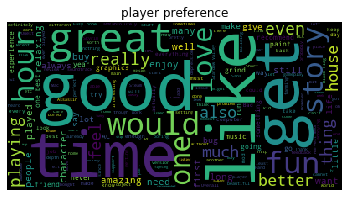

In [46]:
wordcloud=WordCloud(stopwords=all_stops).generate(text)
plt.axis('off')
plt.title('player preference')
plt.imshow(wordcloud)

From all the games this player played, "time" shows up quite a lot but it is unsure just from this wordcloud whether that means a game that takes a lot of time to play or the opposite. The term "story" pops up quite a lot as well giving us a clue that this player enjoys games that has story element to it.





<br>
Using only the stems of each words, I calculate the TF-IDF scores of the reviews

In [35]:
def stemtfidf(text):
    X=stemmed_tfidf.fit_transform(text)
    return X.toarray(),stemmed_tfidf.get_feature_names()

In [36]:
#freq,words=stemvect(for_analysis.values())
tdfscore,tdfwords=stemtfidf(allgamedatabase.values())

/home/seo/environments/my_env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ii', 'iii', 'iv', 'v', 'vi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [37]:
games_tdf=pd.DataFrame(tdfscore,index=allgamedatabase.keys(),columns=tdfwords)

In [70]:
games_tdf.dropna()

,aaa,abandon,abil,abl,able get,abrupt,absolut,absolutely lov,absurd,abus,...,younger,your,youtu,youtub,youtube com,z,zero,zombi,zone,zoom
Radio Violence,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
Car Mechanic Simulator 2018 - Porsche DLC,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.892269,4.813133,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
Faeria - Elements DLC,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.175589,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
Ribbon Racer,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
Roads of Rome: New Generation 2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
Mojo 2,0.0,0.000000,3.150707,2.725772,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.741985,3.175589,3.488476,0.0,0.000000,0.000000,4.61407,0.000000
SNUSE 221,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
AREA 4643,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
The Mummy Pharaoh,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
Eximius - Supporter Pack,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000


These will in turn be used to calculate cosine similarity with each other: matrixforgame

This allows us to find out how similar each game's reviews are to others, which in turn implies how similar each game is to the other

In [51]:
list_of_games=[game for game in games_tdf.index.tolist() if game not in best_list]
listlength=len(list_of_games)
bestlistlength=len(best_list)
import numpy as np
from scipy import spatial
matrixforgame=np.zeros(shape=(listlength,bestlistlength))
for i in range(listlength):
    game=list_of_games[i]
    for j in range(bestlistlength):
        another=best_list[j]
        if game!=another:
            result=1-spatial.distance.cosine(games_tdf.loc[game].values,games_tdf.loc[another].values)
            matrixforgame[i][j]=result

/home/seo/environments/my_env/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [54]:
pickle.dump(matrixforgame,open("cosine_result.pickle","wb"))

In [52]:
from sklearn.externals import joblib
joblib.dump(matrixforgame, "cosine_result2.p")  

/home/seo/environments/my_env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['cosine_result2.p']

In [53]:
from sklearn.externals import joblib
matrixforgame = joblib.load("cosine_result2.p")

In [ ]:
names=list(topplayedgame['name'])

In [77]:
best_list

['Dishonored',
 'The Elder Scrolls IV: Oblivion ',
 "Assassin's Creed Brotherhood",
 "Assassin's Creed II",
 'Ori and the Blind Forest',
 "Assassin's Creed Revelations",
 "Assassin's Creed Rogue",
 "Assassin's Creed® III",
 'The Elder Scrolls V: Skyrim',
 'Stardew Valley',
 "Don't Starve",
 "Assassin's Creed Syndicate",
 'House Flipper',
 "Assassin's Creed IV Black Flag",
 'Undertale']

In [82]:
result_df=pd.DataFrame(matrixforgame,index=list_of_games,columns=best_list)

ValueError: Shape of passed values is (38453, 15), indices imply (38438, 15)

In [71]:
result_df.index

Index(['Radio Violence', 'Car Mechanic Simulator 2018 - Porsche DLC',
       'Faeria - Elements DLC', 'Ribbon Racer',
       'Roads of Rome: New Generation 2', 'Mojo 2', 'SNUSE 221', 'AREA 4643',
       'The Mummy Pharaoh', 'Eximius - Supporter Pack',
       ...
       'Resident Evil 6 / Biohazard 6', 'Insurgency', 'WyVRn', 'Tube Tycoon',
       'Civil War: 1863', 'Direwolf BETA', 'Eleven: Table Tennis VR',
       'Aground', 'Alien Squatter', 'Area 51 Defense'],
      dtype='object', length=38453)

In [105]:
best_df=result_df[topplayedgame['name']]
new_df=pd.DataFrame()
for col in best_df.columns:
    best_val=max(best_df[col])
    #print(col, best_val)
    new_row=best_df.loc[best_df[col]==best_val]
    new_df=new_df.append(new_row)

In [120]:
new_df=pd.DataFrame()
#result_df=result_df.drop(index=best_list)
for col in sorted(list(result_df.columns)):
    similar_game_list=list(result_df[col].sort_values(ascending=False).index)
    dup_removed=[game for game in similar_game_list if game not in list(new_df.index)]
    best_game=dup_removed[0]
    new_row=result_df.loc[best_game]
    new_df=new_df.append(new_row)

Assassin's Creed Brotherhood
            Assassin's Creed Brotherhood  Assassin's Creed II  \
Casino Inc                      0.908451              0.90731   

            Assassin's Creed IV Black Flag  Assassin's Creed Revelations  \
Casino Inc                         0.30313                      0.020845   

            Assassin's Creed Rogue  Assassin's Creed Syndicate  \
Casino Inc                0.081654                    0.079491   

            Assassin's Creed® III  Dishonored  Don't Starve  House Flipper  \
Casino Inc                    0.0    0.073567      0.083769       0.152837   

            Ori and the Blind Forest  Stardew Valley  \
Casino Inc                  0.089582        0.124706   

            The Elder Scrolls IV: Oblivion   The Elder Scrolls V: Skyrim  \
Casino Inc                         0.082051                     0.050554   

            Undertale  
Casino Inc   0.291108  
Assassin's Creed II
                                      Assassin's Creed Brotherh

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   

                                      Assassin's Creed II  \
Casino Inc                                       0.907310   
Shadow Tactics: Blades of the Shogun             0.897663   
Sonic and SEGA All Stars Racing                  0.310795   
Fate/EXTELLA LINK - Young Altera                 0.000000   
Flagsplosion                                     0.028125   

                                      Assassin's Creed IV Black Flag  \
Casino Inc                                                  0.303130   
Shadow Tactics: Blades of the Shogun                        0.286242

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   
Assassin's Creed Odyssey                                  0.145723   
SpaceEngine - Mercury HD                                  0.072882   

                                      Assassin's Creed II  \
Casino Inc                                       0.907310   
Shadow Tactics: Blades of the Shogun             0.897663   
Sonic and SEGA All Stars Racing                  0.310795   
Fate/EXTELLA LINK - Young Altera                 0.000000   
Flagsplosion                                     0.028125   
Assassin's Creed Odyssey                         0.148421   
SpaceEngine 

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   
Assassin's Creed Odyssey                                  0.145723   
SpaceEngine - Mercury HD                                  0.072882   
Metro: Last Light                                         0.135892   
Green Hell                                                0.174276   

                                      Assassin's Creed II  \
Casino Inc                                       0.907310   
Shadow Tactics: Blades of the Shogun             0.897663   
Sonic and SEGA All Stars Racing                  0.310795   
Fate/EXTELLA LINK - Young Altera                 0.0000

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   
Assassin's Creed Odyssey                                  0.145723   
SpaceEngine - Mercury HD                                  0.072882   
Metro: Last Light                                         0.135892   
Green Hell                                                0.174276   
Mini Thief                                                0.147615   

                                      Assassin's Creed II  \
Casino Inc                                       0.907310   
Shadow Tactics: Blades of the Shogun             0.897663   
Sonic and SEGA All Stars Racing               

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   
Assassin's Creed Odyssey                                  0.145723   
SpaceEngine - Mercury HD                                  0.072882   
Metro: Last Light                                         0.135892   
Green Hell                                                0.174276   
Mini Thief                                                0.147615   
SpaceEngine - Pluto System HD                             0.067553   

                                      Assassin's Creed II  \
Casino Inc                                       0.907310   
Shadow Tactics: Blades of the Shogun 

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   
Assassin's Creed Odyssey                                  0.145723   
SpaceEngine - Mercury HD                                  0.072882   
Metro: Last Light                                         0.135892   
Green Hell                                                0.174276   
Mini Thief                                                0.147615   
SpaceEngine - Pluto System HD                             0.067553   
Our Love Will Grow                                        0.095986   

                                      Assassin's Creed II  \
Casino Inc                  

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   
Assassin's Creed Odyssey                                  0.145723   
SpaceEngine - Mercury HD                                  0.072882   
Metro: Last Light                                         0.135892   
Green Hell                                                0.174276   
Mini Thief                                                0.147615   
SpaceEngine - Pluto System HD                             0.067553   
Our Love Will Grow                                        0.095986   
Hero-U: Rogue to Redemption                               0.115008   

                   

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   
Assassin's Creed Odyssey                                  0.145723   
SpaceEngine - Mercury HD                                  0.072882   
Metro: Last Light                                         0.135892   
Green Hell                                                0.174276   
Mini Thief                                                0.147615   
SpaceEngine - Pluto System HD                             0.067553   
Our Love Will Grow                                        0.095986   
Hero-U: Rogue to Redemption                               0.115008   
Demon War           

                                      Assassin's Creed Brotherhood  \
Casino Inc                                                0.908451   
Shadow Tactics: Blades of the Shogun                      0.898792   
Sonic and SEGA All Stars Racing                           0.309684   
Fate/EXTELLA LINK - Young Altera                          0.000000   
Flagsplosion                                              0.026755   
Assassin's Creed Odyssey                                  0.145723   
SpaceEngine - Mercury HD                                  0.072882   
Metro: Last Light                                         0.135892   
Green Hell                                                0.174276   
Mini Thief                                                0.147615   
SpaceEngine - Pluto System HD                             0.067553   
Our Love Will Grow                                        0.095986   
Hero-U: Rogue to Redemption                               0.115008   
Demon War           

In [127]:
new_df.head()

,Assassin's Creed Brotherhood,Assassin's Creed II,Assassin's Creed IV Black Flag,Assassin's Creed Revelations,Assassin's Creed Rogue,Assassin's Creed Syndicate,Assassin's Creed® III,Dishonored,Don't Starve,House Flipper,Ori and the Blind Forest,Stardew Valley,The Elder Scrolls IV: Oblivion,The Elder Scrolls V: Skyrim,Undertale
Casino Inc,0.908451,0.907310,0.303130,0.020845,0.081654,0.079491,0.000000,0.073567,0.083769,0.152837,0.089582,0.124706,0.082051,0.050554,0.291108
Shadow Tactics: Blades of the Shogun,0.898792,0.897663,0.286242,0.045152,0.088169,0.091218,0.000000,0.149674,0.117883,0.152431,0.091431,0.151916,0.083441,0.072646,0.287024
Sonic and SEGA All Stars Racing,0.309684,0.310795,0.843530,0.052178,0.080632,0.096013,0.013617,0.102759,0.101805,0.109233,0.085970,0.161501,0.091385,0.059967,0.232676
Fate/EXTELLA LINK - Young Altera,0.000000,0.000000,0.030136,0.328514,0.000000,0.022231,0.000000,0.045739,0.114185,0.000000,0.000000,0.000000,0.000000,0.000000,0.023031
Flagsplosion,0.026755,0.028125,0.041829,0.011982,0.389424,0.137775,0.027391,0.046369,0.053864,0.057320,0.016598,0.092528,0.031911,0.035970,0.066857


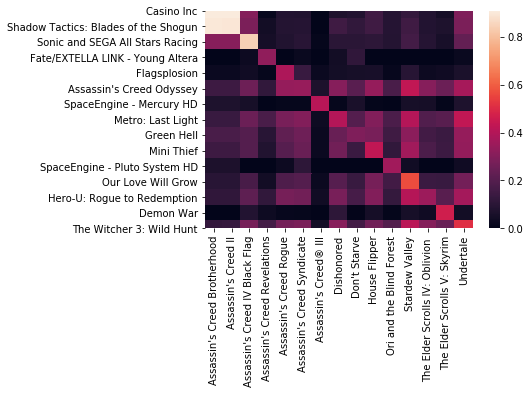

In [122]:
import seaborn as sns
sns.heatmap(new_df)

Looking at the heatmap created by aggregating games with the highest score for each games, games such as 'Assassin's Creed II' and 'Assassin's Creed Brotherhood' shows similar tendency regarding the games it is associated with. This is to be expected because Assassin's Creed Brotherhood is a direct sequel to Assassin's Creed Brotherhood and therefore have very similar style.

<br>

I added weight to each games according to how long the player played it for and added all the cosine similarity values: result_df<br>
This allows me to get a list of games that this player is likely to enjoy because they played these list of games a lot.

In [125]:
weight=len(best_list)
result_df['total'] = 0
for name in best_list:
    result_df['total']=result_df['total']+(weight*result_df[name])
    weight=weight-1

remove the games that this player already possess: removed<br>
Then we take the top 10 games with the largest similarity: finaltop10recommendation

In [128]:
alreadyownedgames=test_df['name'].tolist()
removed=[name for name in result_df.index.tolist() if name not in alreadyownedgames]

In [129]:
finaltop10recommendation=result_df['total'].loc[removed].sort_values(ascending=False)[0:15]
final_list=finaltop10recommendation.index.tolist()

To give users accessibility, I added in urls to each recommended game and presented them: recommended_games

In [130]:
recommended_games=list()
for name in final_list:
    ids=list(steamapp_dict.keys())[list(steamapp_dict.values()).index(name)]
    recommended_games.append((name,"https://store.steampowered.com/app/"+str(ids)))

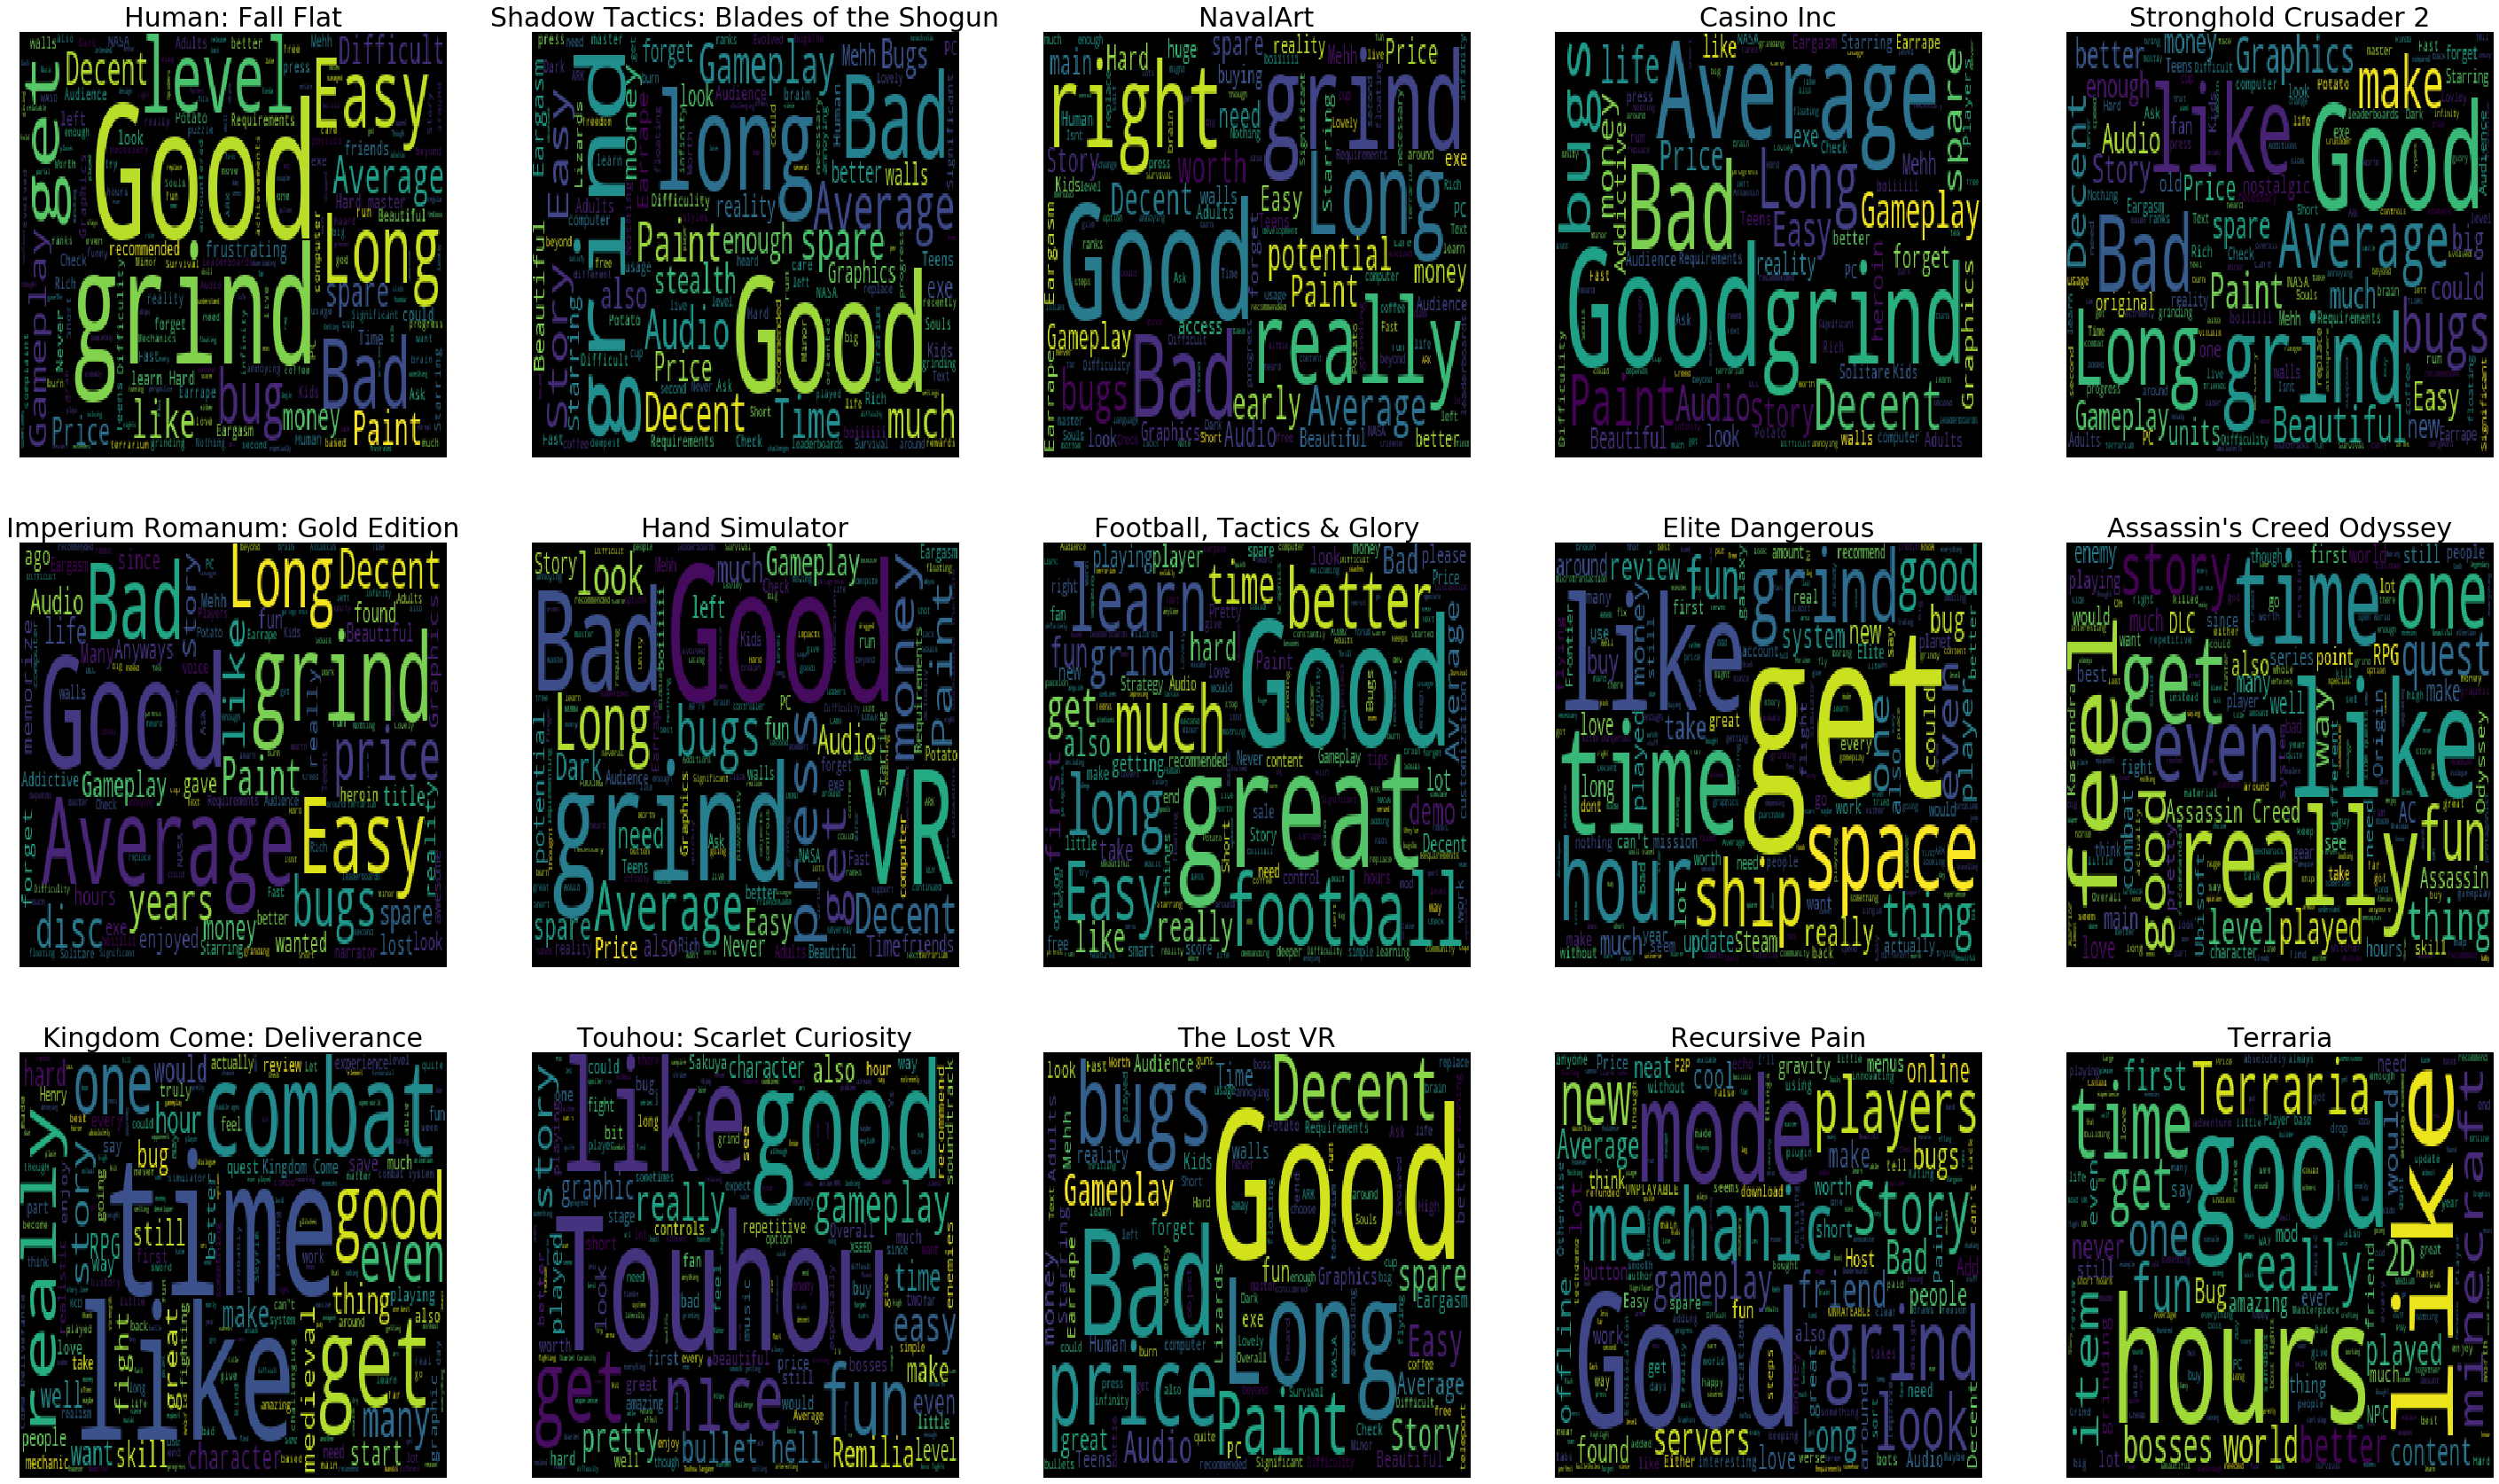

In [131]:
plot_num=1
plt.figure(figsize = (50,30))
for name in final_list:
    working_data=review_df[review_df['game_name']==name]
    text=working_data.review.sum(axis=0)
    wordcloud=WordCloud(stopwords=all_stops).generate(text)
    plt.subplot(3, 5, plot_num)
    plt.gca().set_title(name, fontsize=30)
    plt.imshow(wordcloud,aspect='auto')
    plt.axis('off')
    plot_num=plot_num+1

As shown above, there are a lot of games which mention "time" and "grind" in their word cloud implying the games that are recommended typically has long playtime. Several also has story as its most prominent feature which is something the player prefers.

In [133]:
print("\nBecause you played games such as {}, {} and {}, \n you will like these games as well!\n".format(alreadyownedgames[0],alreadyownedgames[1],alreadyownedgames[2]))
print(pd.DataFrame(recommended_games,columns=["Game Name","Store page"]))


Because you played games such as The Elder Scrolls V: Skyrim, Don't Starve and Assassin's Creed II, 
 you will like these games as well!

                               Game Name  \
0                       Human: Fall Flat   
1   Shadow Tactics: Blades of the Shogun   
2                               NavalArt   
3                             Casino Inc   
4                  Stronghold Crusader 2   
5         Imperium Romanum: Gold Edition   
6                         Hand Simulator   
7              Football, Tactics & Glory   
8                        Elite Dangerous   
9               Assassin's Creed Odyssey   
10             Kingdom Come: Deliverance   
11             Touhou: Scarlet Curiosity   
12                           The Lost VR   
13                        Recursive Pain   
14                              Terraria   

                                    Store page  
0    https://store.steampowered.com/app/477160  
1    https://store.steampowered.com/app/418240  
2    http